<a href="https://colab.research.google.com/github/Prajwal775/Brain_Tumor/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras as keras

In [1]:
from google.colab import files
uploaded = files.upload()


Saving brain tumor dataset.zip to brain tumor dataset.zip


## **Data Loading**

In [5]:
#Unzip data
!unzip '/content/brain tumor dataset.zip'

Archive:  /content/brain tumor dataset.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg

In [6]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
root =  '/content/brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'no': 98, 'yes': 155}

So we have 155 Brain MRI images with a tumor and 98 healthey ones.

Text(0.5, 1.0, 'no')

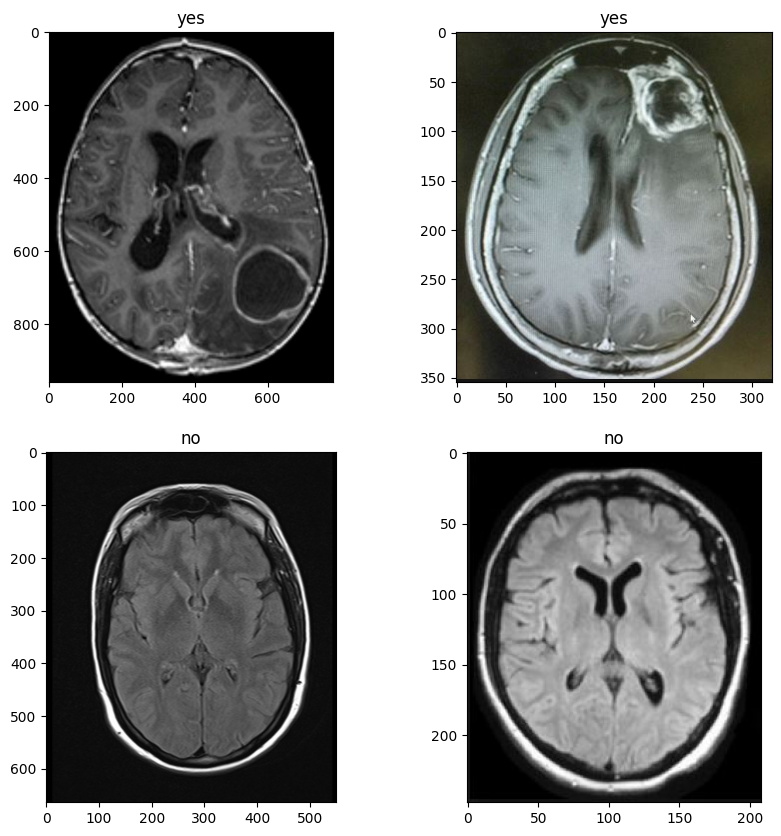

In [7]:
#Plot some MRI images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[0])))
plt.title('yes')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[1])))
plt.title('yes')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[0])))
plt.title('no')
plt.subplot(2, 2, 4)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[1])))
plt.title('no')

## **Image Augmentation**

As much as our training set contains more data, the model's accuracy will improve. Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of already existing data.

In [8]:
#Define a function for image augmentation
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [9]:
#Create augmented images folders
#L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

In [10]:
#Augment data for the examples with the label 'yes' in the training set
augment_data(file_dir='./brain_tumor_dataset/yes',n_generated_samples=8, save_to_dir='./aug_data/yes')
#Augment data for the examples with the label 'no' in the training set
augment_data(file_dir='./brain_tumor_dataset/no', n_generated_samples=12, save_to_dir='./aug_data/no')

## **Split data into train, validation and test sets**

In [11]:
#Count images in the two folders: yes (Tumor) and no (Healthey) in the folder of augmented images
root =  '/content/aug_data'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'no': 1273, 'yes': 1395}

In [12]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [13]:
#Create the training set
create_folders('train', 0.7)

In [14]:
#Create the test set
create_folders('test', 0.15)

In [15]:
#Create the validation set
create_folders('val', 0.15)

In [16]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [17]:
#Count images in the training set
count_img('train')

{'no': 891, 'yes': 976}

In [20]:
#Count images in the test set
count_img('test')

{'no': 190, 'yes': 209}

In [19]:
#Count images in the validation set
count_img('val')

{'no': 190, 'yes': 209}

In [ ]:
# #Define a function for image augmentation
# def augment_data2(file_dir, n_generated_samples, save_to_dir):
#     data_gen = ImageDataGenerator(rescale = 1/255)

#     for filename in os.listdir(file_dir):
#         image = cv2.imread(file_dir + '/' + filename)
#         # reshape the image
#         image = image.reshape((1,)+image.shape)
#         save_prefix = 'aug_' + filename[:-4]
#         i=0
#         for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
#                 i += 1
#                 if i > n_generated_samples:
#                     break

In [ ]:
# #Augment data for the examples with the label 'yes' in the test set
# augment_data2(file_dir='./test/yes',n_generated_samples=8, save_to_dir='./aug_test/yes')
# #Augment data for the examples with the label 'no' in the training set
# augment_data2(file_dir='./test/no', n_generated_samples=12, save_to_dir='./aug_test/no')

In [ ]:
# #Augment data for the examples with the label 'yes' in the validation set
# augment_data2(file_dir='./val/yes',n_generated_samples=8, save_to_dir='./aug_val/yes')
# #Augment data for the examples with the label 'no' in the training set
# augment_data2(file_dir='./val/no', n_generated_samples=12, save_to_dir='./aug_val/no')

In [ ]:
# #Count images in the training set
# count_img('aug_train')

In [ ]:
# #Count images in the training set
# count_img('aug_test')

In [ ]:
# #Count images in the training set
# count_img('aug_val')

## **Image Preprocessing**

In [21]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):

    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

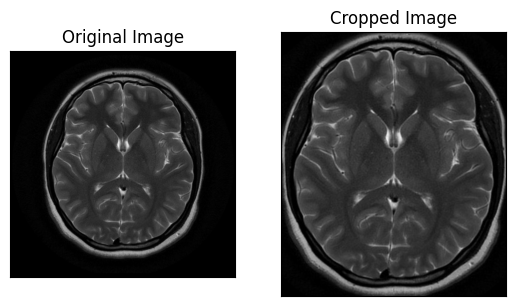

In [22]:
#Example
ex_img = cv2.imread('no/1 no.jpeg')
img = crop_brain_contour(ex_img, plot=True)

In [23]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [24]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/train/yes', '/content/train/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1867
X shape is: (1867, 240, 240, 3)
y shape is: (1867, 1)


In [25]:
#Define a function that plot images
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

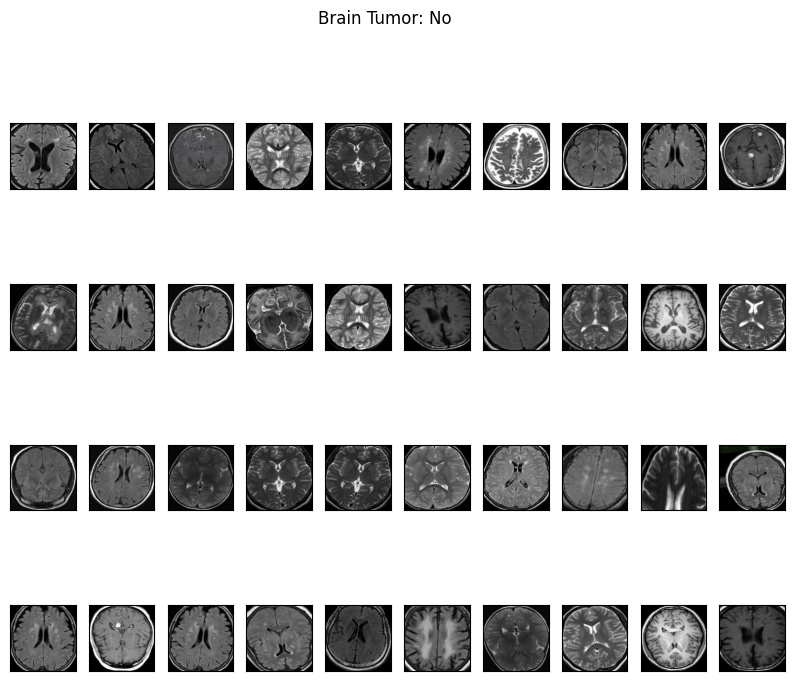

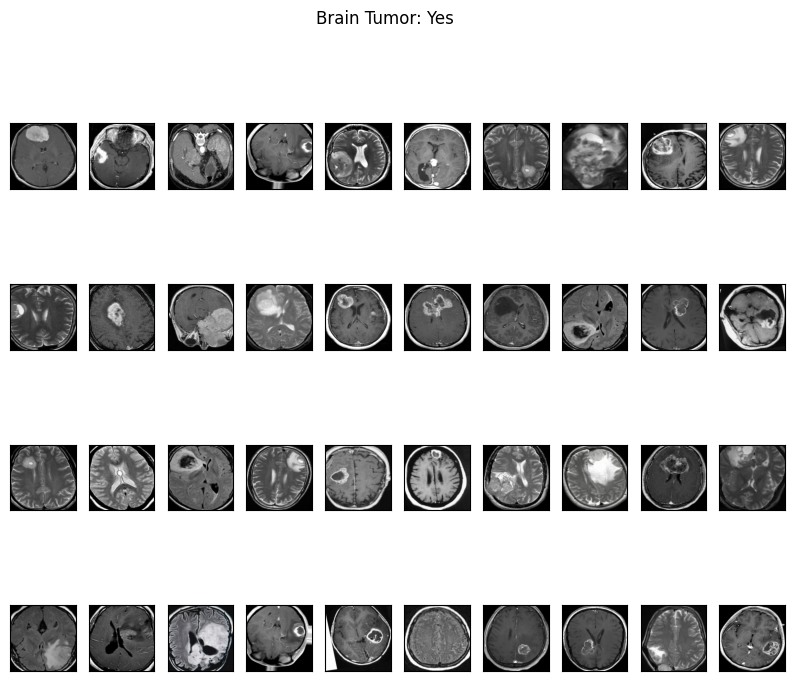

In [26]:
#Plot samples from the training set
plot_sample_images(X_train, y_train)

We can notice that the noise has been deleted and some images look alike with some slight changes resulted from the data augmentation

In [27]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/yes', '/content/test/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 399
X shape is: (399, 240, 240, 3)
y shape is: (399, 1)


In [28]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/yes', '/content/val/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 399
X shape is: (399, 240, 240, 3)
y shape is: (399, 1)


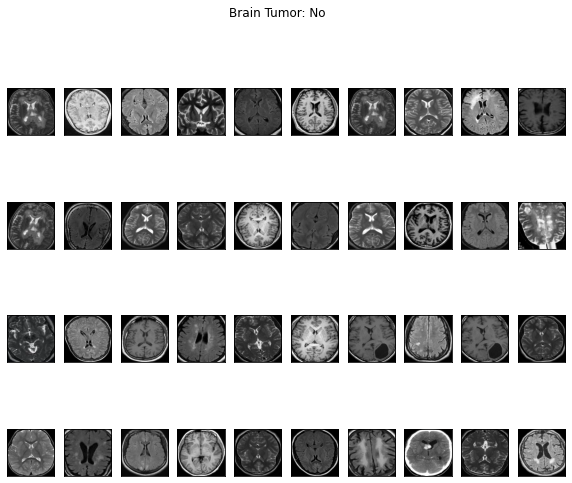

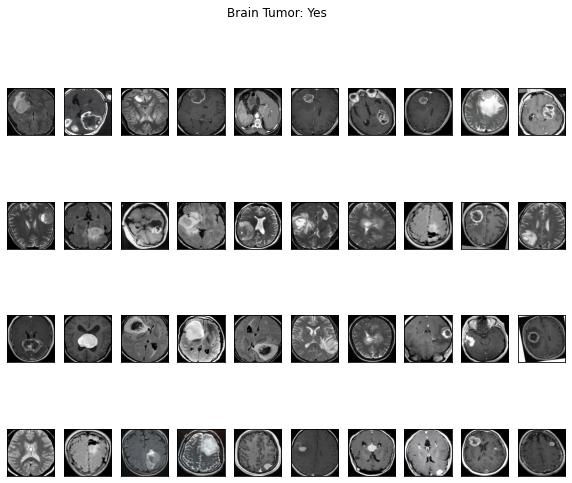

In [ ]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

## **CNN Model**

In [29]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 238, 238, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 236, 236, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 118, 118, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 116, 116, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,520,097 (24.87 MB)

 Trainable params: 6,520,097 (24.87 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [32]:
from google.colab import files
uploaded = files.upload()


Saving besttransfermodel.h5 to besttransfermodel.h5


In [34]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.keras', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [35]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5302 - loss: 0.7300
Epoch 1: val_accuracy improved from -inf to 0.76942, saving model to ./bestmodel.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 262ms/step - accuracy: 0.5307 - loss: 0.7291 - val_accuracy: 0.7694 - val_loss: 0.5043
Epoch 2/30
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7060 - loss: 0.5733
Epoch 2: val_accuracy improved from 0.76942 to 0.80702, saving model to ./bestmodel.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.7071 - loss: 0.5718 - val_accuracy: 0.8070 - val_loss: 0.4393
Epoch 3/30
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8182 - loss: 0.4059
Epoch 3: val_accuracy improved from 0.80702 to 0.85965, saving model to ./bestmodel.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.8185 - loss: 0.4055 - val_accuracy: 0.8596 - val_loss: 0.3478
Epoch 4/30
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8390 - loss: 0.3694
Epoch 4: val_accuracy improved from 0.859

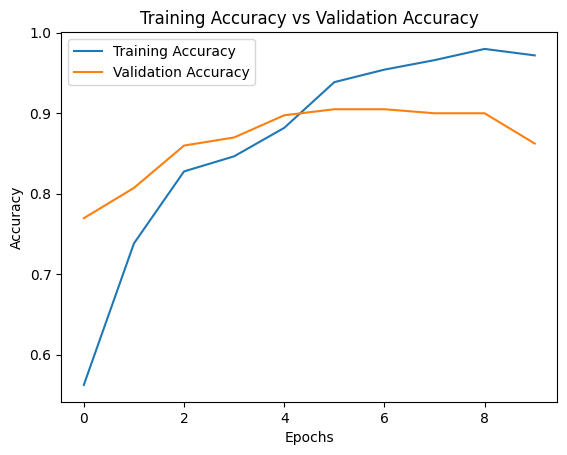

In [36]:
#Plot the graphical interpretation
# Extract history
h = hist.history

# Plot training and validation accuracy
plt.plot(h['accuracy'], label='Training Accuracy')
plt.plot(h['val_accuracy'], label='Validation Accuracy')

# Add title and labels
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add legend to differentiate the lines
plt.legend()

# Show the plot
plt.show()

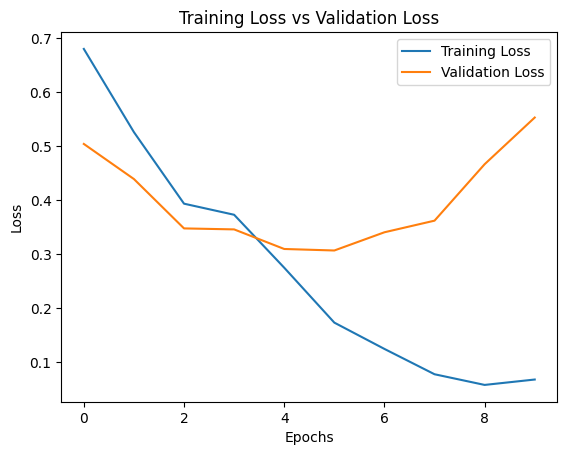

In [37]:

# Extract history
h = hist.history

# Plot training and validation loss
plt.plot(h['loss'], label='Training Loss')
plt.plot(h['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend to differentiate the lines
plt.legend()

# Show the plot
plt.show()

In [40]:
import os
print(os.getcwd())


/content


In [41]:
print(os.listdir('./'))


['.config', 'besttransfermodel.h5', 'brain_tumor_dataset', 'no', 'brain tumor dataset.zip', 'test', 'val', 'bestmodel.keras', 'train', 'yes', 'aug_data', 'sample_data']


In [42]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/bestmodel.keras')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8937 - loss: 0.3890
The accuracy of our model is 0.8721804618835449


In [44]:
import os
print(os.listdir('/content/aug_data/yes/'))


['aug_Y35_0_7650.jpg']


We can see that our model works well on the test set, so it's not overfitted

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


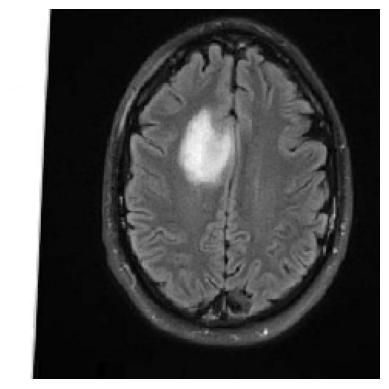

The MRI image has a tumor


In [47]:
#Try our model on a random image that it has never seen before
from keras.preprocessing.image import load_img, img_to_array
#Choose a MRI image with tumor
path = "/content/aug_data/yes/aug_Y35_0_7650.jpg"
img_yes = load_img(path, target_size=(240,240))
img_array_yes = img_to_array(img_yes)/255
img_array_yes = np.expand_dims(img_array_yes, axis=0)
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)

# Display the image
plt.imshow(img_yes)
plt.axis('off')  # Turn off axis labels
plt.show()

if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

## **Transfer Learning**

In [57]:
#Import MobileNet Model
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(240,240,3), include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [58]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [59]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [60]:
transfer_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 120, 120, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 120, 120, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 120, 120, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 120, 120, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 120, 120, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 120, 120, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 121, 121, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 60, 60, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 60, 60, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 60, 60, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 60, 60, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 60, 60, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 60, 60, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 60, 60, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,279,041 (12.51 MB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [61]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [63]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.keras', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [64]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7277 - loss: 4.1475
Epoch 1: val_accuracy improved from -inf to 0.97744, saving model to ./besttransfermodel.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.7293 - loss: 4.1130 - val_accuracy: 0.9774 - val_loss: 0.1185
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9416 - loss: 0.8014
Epoch 2: val_accuracy improved from 0.97744 to 0.98747, saving model to ./besttransfermodel.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9417 - loss: 0.8010 - val_accuracy: 0.9875 - val_loss: 0.0487
Epoch 3/30
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9588 - loss: 0.5791
Epoch 3: val_accuracy improved from 0.98747 to 0.99499, saving model to ./besttransfermodel.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9591 - loss: 0.5716 - val_accuracy: 0.9950 - val_loss: 0.0392
Epoch 4/30
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9842 - loss: 0.2167
Epoch 4: val_accura

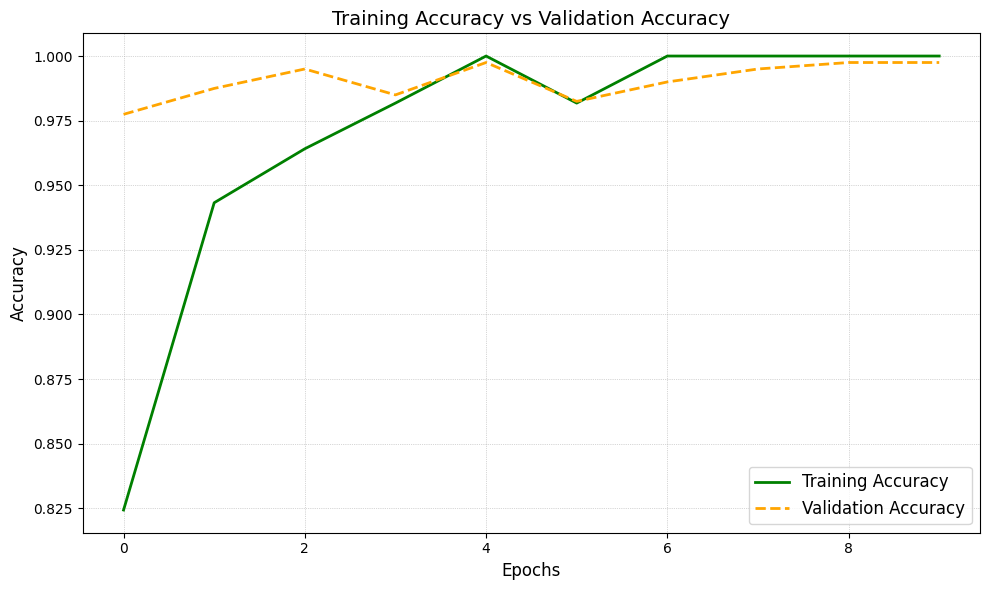

In [65]:
#Plot the graphical interpretation
# Extract history
h = transfer_hist.history

# Plot training and validation accuracy with improvements
plt.figure(figsize=(10, 6))  # Adjust figure size for better visibility
plt.plot(h['accuracy'], label='Training Accuracy', color='green', linestyle='-', linewidth=2)
plt.plot(h['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)

# Add title and labels with improved font size
plt.title('Training Accuracy vs Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Add legend to differentiate the lines
plt.legend(loc='lower right', fontsize=12)

# Add grid for better readability
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout to ensure labels don't get cut off
plt.show()


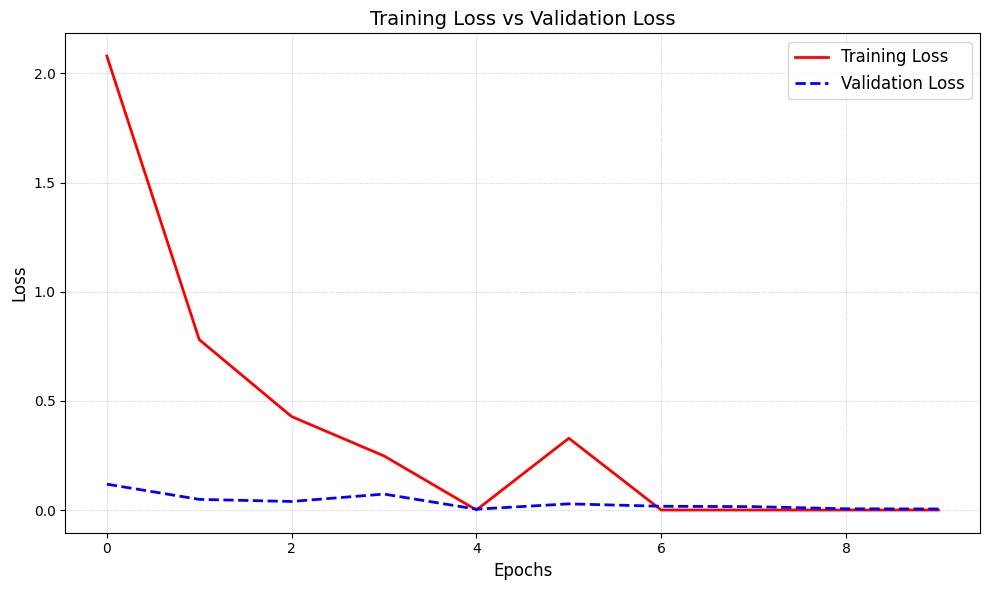

In [66]:
# Extract history
h = transfer_hist.history

# Plot training and validation loss with improvements
plt.figure(figsize=(10, 6))  # Adjust figure size for better visibility
plt.plot(h['loss'], label='Training Loss', color='red', linestyle='-', linewidth=2)
plt.plot(h['val_loss'], label='Validation Loss', color='blue', linestyle='--', linewidth=2)

# Add title and labels with improved font size
plt.title('Training Loss vs Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add legend to differentiate the lines
plt.legend(loc='upper right', fontsize=12)

# Add grid for better readability
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout to ensure labels don't get cut off
plt.show()
